# Surroaget Analysis

[a.k.a (Approximation model), (Response Surface Model,RSM), Emulator]

## Global Surrogate

#### [잘알려진 XAI 알고리즘과 알고리즘 각가의 특성을 정리한 표]    
|알고리즘| 선형성(Linearity) | 단조함수 유무(Monotone)| PDP Interaction |목표|
|----------|----------|----------|----------|----------|
| 선형 회귀 | 있음 | 단조함수 | 불가능 | 회귀 |
| 로지스틱 회귀 | 없음 | 단조함수 | 불가능 | 분류 |
| 의사 결정 트리 | 없음 | 일부 | 가능 | 분류,회귀 | 
| 나이브 베이즈 | 없음 | 단조함수 | 불가능 | 분류 | 
| K-nn | 없음 | 단조함수 아님 | 불가능 | 분류,회귀 |


##### 수행과정 
1. 데이터 집합 x를 선택, (x 데이터 집합 전체 or 일부)    
2. 선택한 데이터 집합 x에 대해 블랙박스 모델 f의 예측 결과를 구한다.     
3. XAI 모델 선택, 학습한 결과를 모델 g.      
4. 모델 g는 설명 가능해야함     
5. 데이터 집합 x로 모델 g를 학습시킨다.     
6. 데이터 x에 대해 모델 f가 예측한 결과(2)와 모델 g의 예측결과를 비교하면서    
   두 모델이 최대한 유사한 결과를 내도록 튜닝    
7. (6)의 과정이 긑나면 설명 가능한 모델 g를 XAI 기법을 사용해 해석

## Local Surrogate

#### LIME(Local Interpretable Model-agnostic Explainations)
(학습 기법과 관계없이 모델을 설명할 수 있는 로컬 설명 가능 모델)

#### Practice :Applying LIME to text data

In [1]:
#  Code to import the 20 news groups dataset from the sklearn package

from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test =    fetch_20newsgroups(subset='test')

# making class names shorter
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:]) for x in newsgroups_train.target_names]

print(class_names)

class_names[3] = 'pc.hardware'
class_names[4] = 'mac.hardware'
print(class_names)


['atheism', 'graphics', 'ms-windows.misc', 'hardware', 'hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']
['atheism', 'graphics', 'ms-windows.misc', 'pc.hardware', 'mac.hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']


In [2]:
# Code to create a model to classify the categories of reported articles and measure the F1-score

import sklearn
import sklearn.metrics
from sklearn.naive_bayes import MultinomialNB

# TF-IDF text -> vector  | data preprocessing
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# learning
# MultinomiaNB(Mulitnomail Navie Bayes)
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)

# testing
pred = nb.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='weighted')


0.8350184193998174

In [3]:
# Process of performing data vectorizer and category classification 
# at the same time on test data index 0 using pipeline technology

from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vectorizer, nb)
predict_classes = pipe.predict_proba([newsgroups_test.data[0]]).round(3)[0]

print(predict_classes)


[0.001 0.01  0.003 0.047 0.006 0.002 0.003 0.521 0.022 0.008 0.025 0.
 0.331 0.003 0.006 0.    0.003 0.    0.001 0.009]


In [4]:
# Modify the output to improve the readability of data classification results

rank = sorted(range(len(predict_classes)),
              key=lambda i: predict_classes[i],
              reverse=True)

for rank_index in rank:
    print('[{:>5}] \t{:<3}\tclass ({:.1%})'.format(rank.index(rank_index) + 1, rank_index, predict_classes[rank_index]))


[    1] 	7  	class (52.1%)
[    2] 	12 	class (33.1%)
[    3] 	3  	class (4.7%)
[    4] 	10 	class (2.5%)
[    5] 	8  	class (2.2%)
[    6] 	1  	class (1.0%)
[    7] 	19 	class (0.9%)
[    8] 	9  	class (0.8%)
[    9] 	4  	class (0.6%)
[   10] 	14 	class (0.6%)
[   11] 	2  	class (0.3%)
[   12] 	6  	class (0.3%)
[   13] 	13 	class (0.3%)
[   14] 	16 	class (0.3%)
[   15] 	5  	class (0.2%)
[   16] 	0  	class (0.1%)
[   17] 	18 	class (0.1%)
[   18] 	11 	class (0.0%)
[   19] 	15 	class (0.0%)
[   20] 	17 	class (0.0%)


In [5]:
#  Code declaring LIME text description

# ! pip install lime


from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)


In [6]:
# explainer.explain_instance() method need at least 2 parameter
# explained target data, model


exp = explainer.explain_instance(newsgroups_test.data[0], pipe.predict_proba, top_labels=1)

In [7]:
# Check the LIME worked

exp.available_labels()

[7]

In [8]:
# Code that outputs the explainer's interpretation of test data 0 to an iPython notebook
# explainer print class 7
# class 7 is autos category

exp.show_in_notebook(text=newsgroups_test.data[0])

In [9]:
#  Input test data number 5 into the LIME algorithm

from lime.lime_text import LimeTextExplainer

idx = 5

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(newsgroups_test.data[idx], pipe.predict_proba, top_labels=1)
predict_classes = pipe.predict_proba([newsgroups_test.data[idx]]).round(3)[0]
rank = sorted(range(len(predict_classes)), key=lambda i: predict_classes[i], reverse=True)

print('Document id: %d' % idx)
print('Predicted class: %s' % class_names[nb.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[newsgroups_test.target[idx]])
print(predict_classes)

print(rank)
print ('Explanation for class %s' % class_names[rank[0]])
print ('\n'.join(map(str, exp.as_list(rank[0]))))

exp.show_in_notebook(text=newsgroups_test.data[idx])

Document id: 5
Predicted class: med
True class: med
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
Explanation for class med
('Candida', 0.0019136162847052981)
('fungus', 0.0017878876232522367)
('yeast', 0.001749011497731866)
('infection', 0.0016451907861383386)
('infections', 0.001596448182204292)
('systemic', 0.0015696618111261142)
('Yeast', 0.0015368951494883543)
('Dyer', 0.0014894480497178043)
('patients', 0.0014029758855062919)
('B12', 0.0001772691849338238)


## Practice : Apply LIME to image data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/jangseokhee/scikit_learn_data


(-0.5, 1279.5, 1279.5, -0.5)

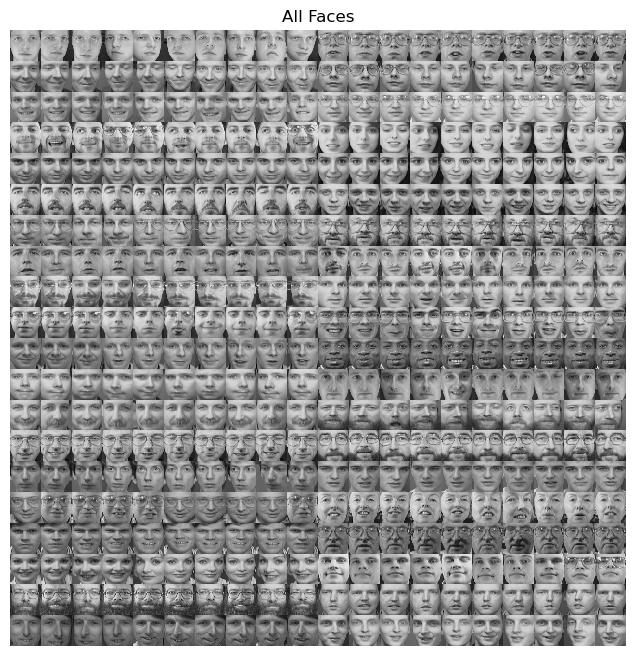

In [10]:
# Code to load and check Olivetti face data using the scikit-image package

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray

from skimage.util import montage

from sklearn.datasets import fetch_olivetti_faces           # fetch_olivetti_face dataset
# 1992-1994 AT&T lab collect olivetti_face img
# each img 8bit(gray-scale) size 64*64
faces = fetch_olivetti_faces()

# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8)           #save data label int type

%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.imshow(montage(X_vec[:,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')


(-0.5, 63.5, 63.5, -0.5)

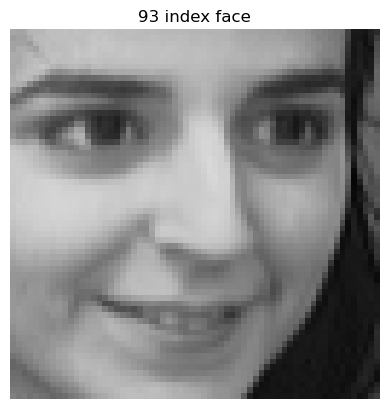

In [11]:
# Code to draw a piece of image data

index = 93
plt.imshow(X_vec[index], cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

In [12]:
# Code that matches conventions so that a classification model
# using TensorFlow can be used in LIME

def predict_proba(image):
    return session.run(model_predict, feed_dict={preprocessed_image: image})

In [13]:
# Code to separate training and testing datasets from X_vec and y_vec 
# using the train_test_split function in the sklearn package.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, train_size=0.70)

In [14]:
# Creating a pipeline that performs image preprocessing so that MLP can learn
# MLP(Multi-layer Perceptron Classifier) used for PoC(Proof of Concept)

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
class PipeStep(object):
    """ 
        Wrapper for turning functions into pipeline transforms (no-fitting) 
    """
    def __init__(self, step_func):
        self._step_func=step_func
        
    def fit(self,*args):
        return self
    
    def transform(self,X):
        return self._step_func(X)
    

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('MLP', MLPClassifier(
        activation='relu',
        hidden_layer_sizes=(400, 40),
    random_state=1))
])


In [15]:
# Code for pouring training data into a pipeline with MLP
simple_pipeline.fit(X_train, y_train)

/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x14a602b90>),
                ('Flatten Image', <__main__.PipeStep object at 0x14a600b90>),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), random_state=1))])

In [16]:
# Code to test model performance using classification_report

def test_model(X_test, y_test):
  pipe_pred_test = simple_pipeline.predict(X_test)
  pipe_pred_prop = simple_pipeline.predict_proba(X_test)

  from sklearn.metrics import classification_report
  print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

test_model(X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.20      1.00      0.33         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       0.12      1.00      0.22         2
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.33      1.00      0.50         3
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jangseokhee

In [17]:
# Code that trains MLP by adding the Normalizer preprocessing process

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
class PipeStep(object):
    """ Wrapper for turning functions into pipeline transforms (no-fitting) """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    # add Normalizer preprocessing step
    ('MLP', MLPClassifier(
        activation='relu',
        hidden_layer_sizes=(400, 40),
        random_state=1)),
])

simple_pipeline.fit(X_train, y_train)

test_model(X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.50      0.67      0.57         3
           3       0.67      1.00      0.80         2
           4       0.67      0.50      0.57         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       0.67      0.33      0.44         6
           8       0.67      1.00      0.80         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         2
          13       0.60      1.00      0.75         3
          14       1.00      0.60      0.75         5
          15       0.00      0.00      0.00         1
          16       1.00      0.75      0.86         4
          17       0.50    

/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: Un

In [18]:

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    # add Normalizer preprocessing step
    ('MLP', MLPClassifier(
        activation='relu',
        alpha=1e-7,
        epsilon=1e-6,
        hidden_layer_sizes=(800, 120),
        random_state=1)),
])

simple_pipeline.fit(X_train, y_train)

test_model(X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      0.83      0.91         6
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         3
          12       0.67      1.00      0.80         2
          13       0.75      1.00      0.86         3
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         1
          16       1.00      0.75      0.86         4
          17       1.00    

/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
# Code declaring sharing an image with LIME's image description

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

# segmenter algorithms: quickshift(default), slic, felzenszwalb
segmenter = SegmentationAlgorithm(
        'slic',
        n_segments=100,
        compactness=1,
        sigma=1)                        #smoothing


In [23]:
%%time

# Code to build an explanation model for test image 0

olivetti_test_index = 0

exp = explainer.explain_instance(
    X_test[olivetti_test_index],
    classifier_fn = simple_pipeline.predict_proba,
    top_labels=6,
    num_samples=1000,
    segmentation_fn=segmenter)


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 7.91 s, sys: 279 ms, total: 8.19 s
Wall time: 1.36 s


Text(0.5, 1.0, 'Show mask only')

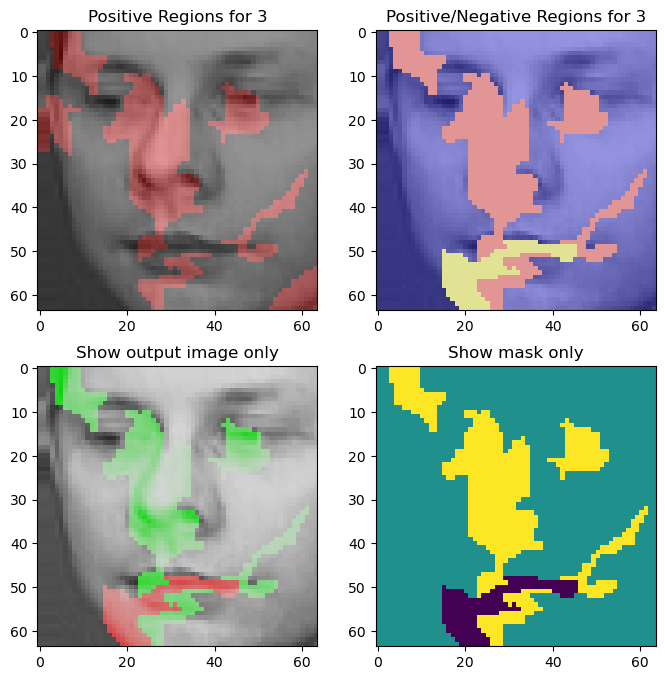

In [24]:
# 예제 5.21 올리베티 데이터 0번을 설명체에 통과시켜 XAI를 수행하는 코드

from skimage.color import label2rgb
# set canvas
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (8, 8))

# show positive segments
temp, mask = exp.get_image_and_mask(
    y_test[olivetti_test_index],
    positive_only=True,
    num_features=8,
    hide_rest=False)

ax1.imshow(
        label2rgb(mask, temp, bg_label = 0),
        interpolation = 'nearest')

ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))

# show all segments
temp, mask = exp.get_image_and_mask(
    y_test[olivetti_test_index],
    positive_only=False,
    num_features=8,
    hide_rest=False)

ax2.imshow(
    label2rgb(4 - mask, temp, bg_label = 0),
    interpolation = 'nearest')

ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

# show image only
ax3.imshow(temp, interpolation = 'nearest')
ax3.set_title('Show output image only')

# show mask only
ax4.imshow(mask, interpolation = 'nearest')
ax4.set_title('Show mask only')

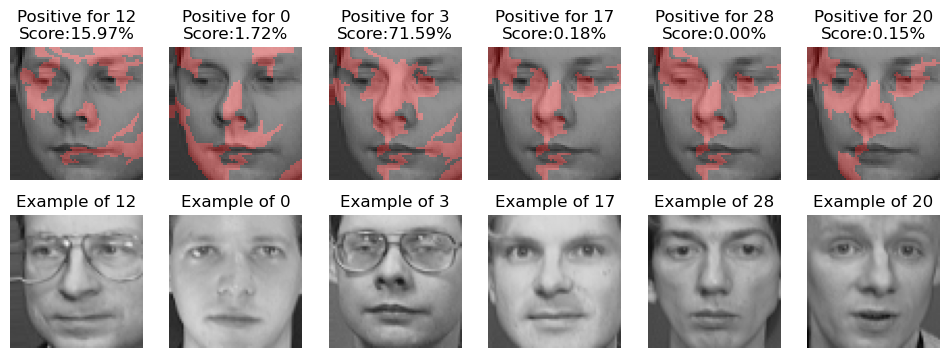

In [25]:
# Code to output additional explanation from Olivetti face test data number 0 (person number 3)

def show_extra_info(test, test_index):

    pipe_pred_test = simple_pipeline.predict(test)
    pipe_pred_prop = simple_pipeline.predict_proba(test)
    # now show them for each class
    fig, m_axs = plt.subplots(2,6, figsize = (12,4))
    for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
        temp, mask = exp.get_image_and_mask(
                i,
                positive_only=True,
                num_features=12,
                hide_rest=False,
                min_weight=0.001)

        c_ax.imshow(
                label2rgb(mask,temp, bg_label = 0),
                interpolation = 'nearest')
        c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[test_index, i]))

        c_ax.axis('off')

        face_id = np.random.choice(np.where(y_train==i)[0])

        gt_ax.imshow(X_train[face_id])
        gt_ax.set_title('Example of {}'.format(i))
        gt_ax.axis('off')

show_extra_info(X_test, 1)

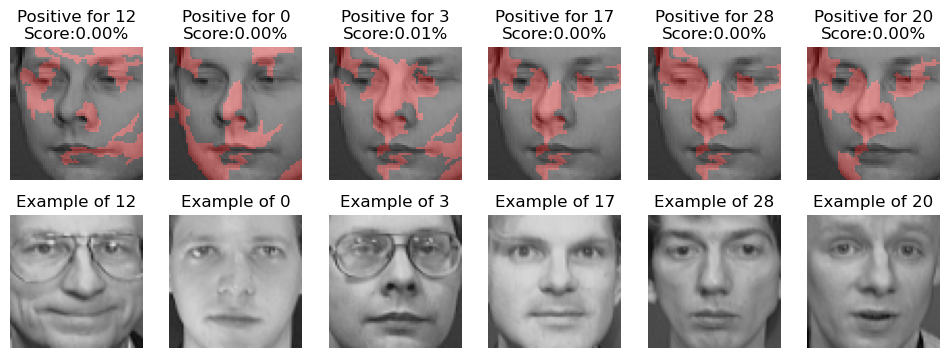

In [26]:
show_extra_info(X_test, 25)

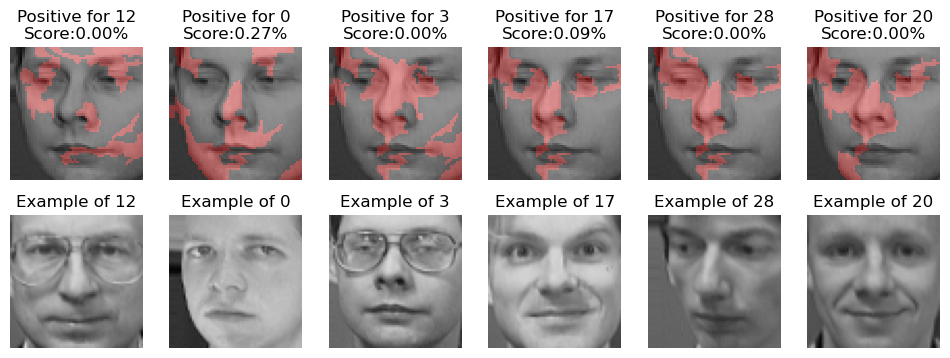

In [27]:
show_extra_info(X_test, 101)

## SHAP(SHapley Additive exPlanations)  

- SHAP (SHapley Additive exPlanations)  
https://medium.com/@corymaklin/shap-shapley-additive-explanations-b8f0fce06202

- 보스턴 데이터 특징 설명
    - CRIM: 지역별 범죄 발생률
    - ZN: 25,000평방피트를 초과하는 거주 지역의 비율
    - NDUS: 비상업 지역 넓이 비율
    - CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
    - NOX: 일산화질소 농도
    - RM: 거주할 수 있는 방 개수
    - AGE: 1940년 이전에 건축된 소유 주택의 비율
    - DIS: 5개 주요 고용센터까지의 가중 거리
    - RAD: 고속도로 접근 용이도
    - TAX: 10,000달러당 재산세율
    - PTRATIO: 지역의 교사와 학생 수 비율
    - B: 지역의 흑인 거주 비율
    - LSTAT: 하위 계층의 비율    
    
    - MEDV: 본인 소유의 주택 가격(중앙값) - 종속변수 (위의 건 독립변수)

In [1]:
import pandas as pd

# X, y = shap.datasets.boston()
boston = pd.read_csv('BostonHousing.csv')

In [2]:
boston.head(2)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   

       b  lstat  medv  
0  396.9   4.98  24.0  
1  396.9   9.14  21.6

In [3]:
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')

In [28]:
import chardet

encoding = chardet.detect(open("BostonHousing.csv", "rb").read()).get("encoding")
print(encoding)
# df = pd.read_csv("BostonHousing.csv", encoding=encoding)

ascii


In [1]:
"""[og_code]"""
# !pip install shap
# import shap
# from sklearn.model_selection import train_test_split

# X, y = shap.datasets.boston()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train[:10]



"""
    [Convert Code]
    now after sklearn 0.26 didn't service boston price dataset (cuz Racism)
"""
import shap
from sklearn.model_selection import train_test_split
import pandas as pd

# X, y = shap.datasets.boston()
boston = pd.read_csv('BostonHousing.csv')
X = boston.drop('medv', axis=1)
y = boston['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train[:10]



crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
42    0.14150   0.0   6.91     0  0.448  6.169   6.6  5.7209    3  233   
58    0.15445  25.0   5.13     0  0.453  6.145  29.2  7.8148    8  284   
385  16.81180   0.0  18.10     0  0.700  5.277  98.1  1.4261   24  666   
78    0.05646   0.0  12.83     0  0.437  6.232  53.7  5.0141    5  398   
424   8.79212   0.0  18.10     0  0.584  5.565  70.6  2.0635   24  666   
160   1.27346   0.0  19.58     1  0.605  6.250  92.6  1.7984    5  403   
185   0.06047   0.0   2.46     0  0.488  6.153  68.8  3.2797    3  193   
101   0.11432   0.0   8.56     0  0.520  6.781  71.3  2.8561    5  384   
268   0.54050  20.0   3.97     0  0.575  7.470  52.6  2.8720    5  264   
173   0.09178   0.0   4.05     0  0.510  6.416  84.1  2.6463    5  296   

     ptratio       b  lstat  
42      17.9  383.37   5.81  
58      19.7  390.68   6.86  
385     20.2  396.90  30.81  
78      18.7  386.40  12.34  
424     20.2    3.65  17.16  
160     14.7  338.92   5.50  
185     17.8  387.11  13.15  
101     20.9  395.58   7.67  
268     13.0  390.30   3.16  
173     16.6  395.50   9.04

Text(0, 0.5, 'MEDV \n Price $1,000')

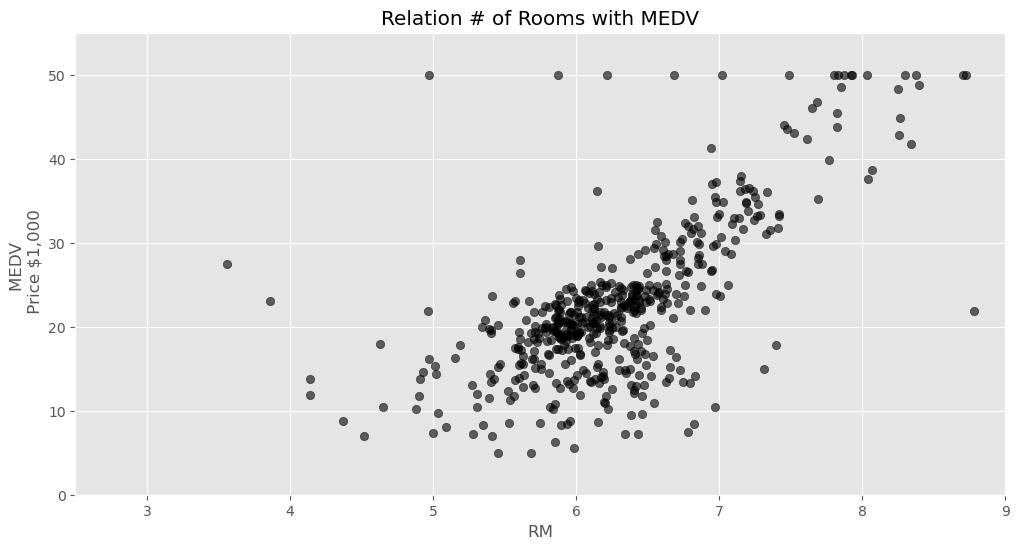

In [2]:
# Code to create a scatter plot of the relationship between room changes and house prices

# drawing scatter plot
import matplotlib.pylab as plt
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

fig, ax1 = plt.subplots(1,1, figsize = (12,6))

ax1.scatter(X['rm'], y, color='black', alpha=0.6)
ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('RM')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')


In [3]:
# Code to find the relationship between the number of rooms and house price using a linear model

from sklearn import linear_model
import pandas as pd

linear_regression = linear_model.LinearRegression()
linear_regression.fit(X=pd.DataFrame(X_train['rm']), y=y_train)
prediction = linear_regression.predict(X=pd.DataFrame(X_test['rm']))

print('a value: ', linear_regression.intercept_)
print('b value: ', linear_regression.coef_)
print('MEDV = {:.2f} * RM {:.2f}'.format(linear_regression.coef_[0], linear_regression.intercept_))


a value:  -32.39552264560757
b value:  [8.76050748]
MEDV = 8.76 * RM -32.40


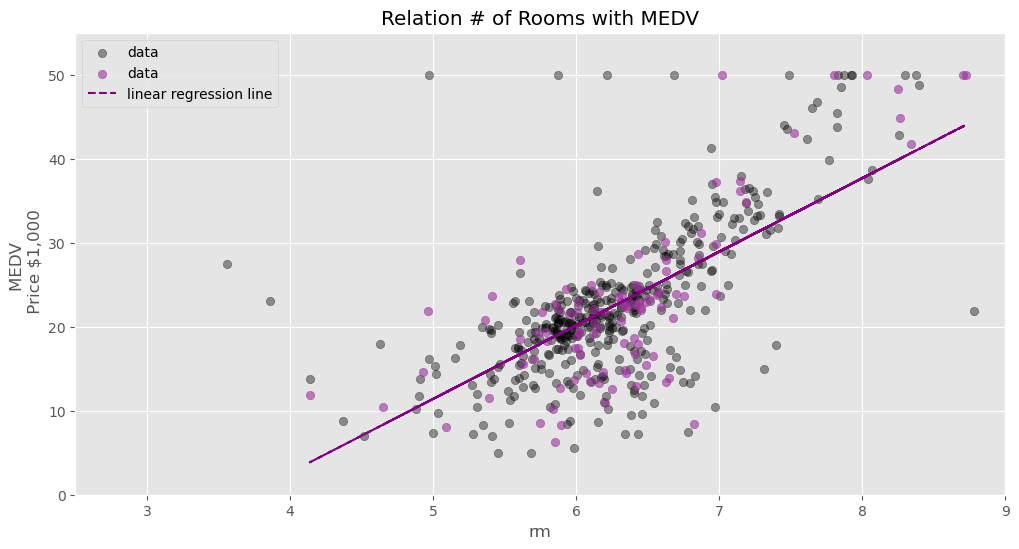

In [4]:
# Code that plots a graph and data that predicts the sale price of a house when the number of rooms varies

# scatter Train, Test data with Linear Regression Prediction
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
ax1.scatter(X_train['rm'], y_train, color='black', alpha=0.4, label='data')
ax1.scatter(X_test['rm'], y_test, color='#993299', alpha=0.6, label='data')
ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('rm')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')
ax1.plot(X_test['rm'], prediction, color='purple', alpha=1, linestyle='--', label='linear regression line')
ax1.legend()


In [5]:
# Code to calculate RMSE between model predictions and actual house prices
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE: %f" % (rmse))


RMSE: 6.383135


In [6]:
# Code to create and train a model to predict home sale price with xgboost's linear regression model

import xgboost

# train XGBoost model
model = xgboost.XGBRegressor(objective ='reg:linear')
model.fit(X_train, y_train)
preds = model.predict(X_test)


[03:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
#  Code to calculate the RMSE of a model trained using all features

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 3.099807


In [8]:
import shap
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
# (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])


[03:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Text(0, 0.5, 'MEDV \n Price $1,000')

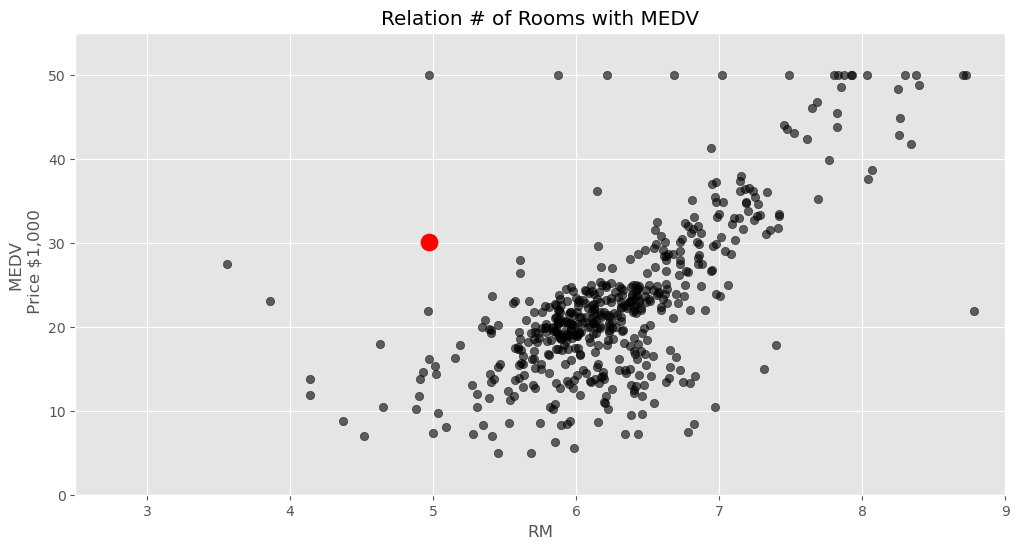

In [9]:

fig, ax1 = plt.subplots(1,1, figsize = (12,6))

idx = 259
ax1.scatter(X['rm'], y, color='black', alpha=0.6)
ax1.scatter(X_train['rm'].iloc[idx], y_train[idx], c='red', s=150)
ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('RM')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')


In [10]:

# load JS visualization code to notebook
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[259,:], X_train.iloc[259,:])


In [11]:


# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)


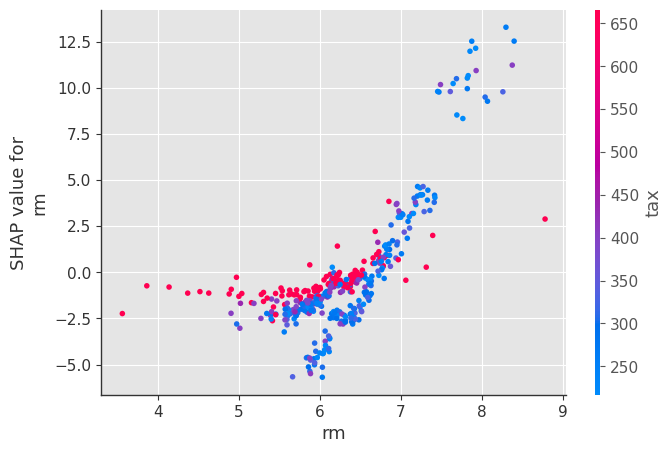

In [13]:

# create a SHAP dependence plot to show the effect
# of a single feature across the whole dataset
shap.dependence_plot("rm", shap_values, X_train)


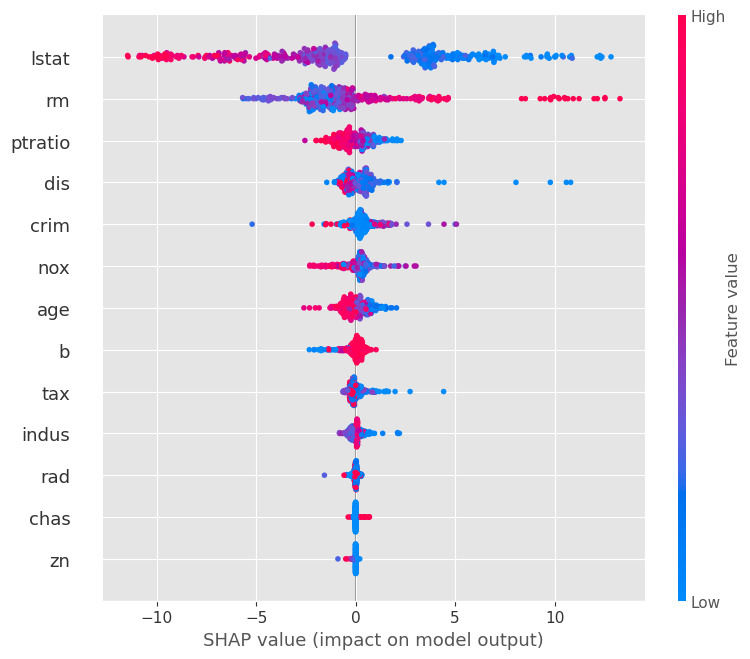

In [14]:

# summarize the effects of all the features

shap.summary_plot(shap_values, X_train)

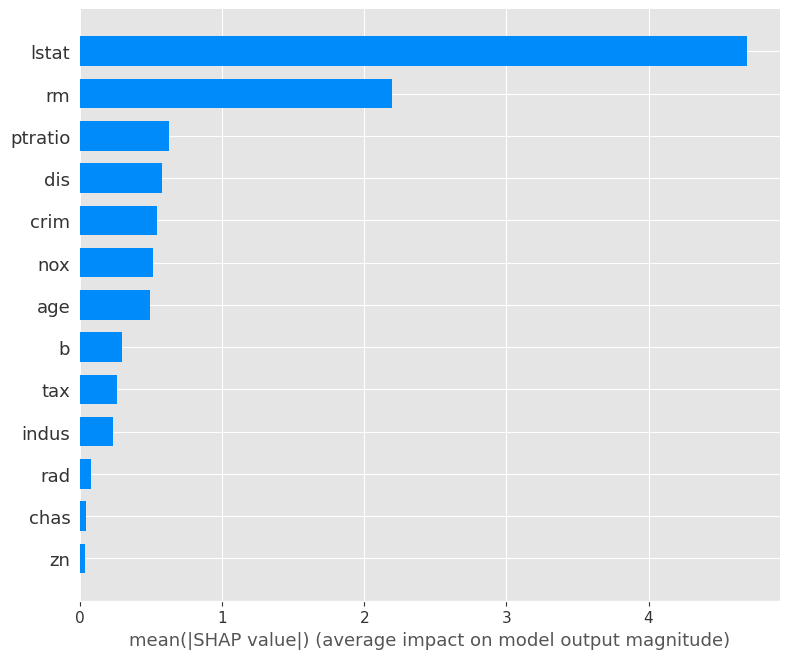

In [15]:

shap.summary_plot(shap_values, X_train, plot_type="bar")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

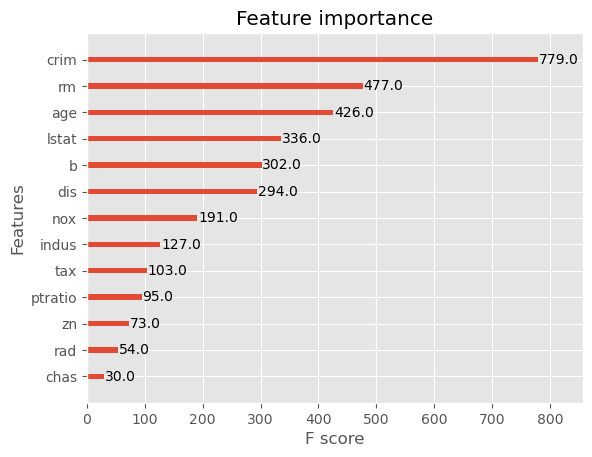

In [16]:

xgboost.plot_importance(model)